In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newdataset6/new6_data (1).csv


In [2]:
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data = '../input/newdataset6/new6_data (1).csv'

df = pd.read_csv(data, header=None)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,2,7,8,9,10,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#load csv file
Train = pd.read_csv('../input/newdataset6/new6_data (1).csv')
data=Train
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,...,text,hashtags,source,is_retweet,Positive,Negative,Neutral,Compound,Sentiment,cleaned
0,0,0,0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64.0,11.0,110.0,...,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,False,0.148,0.000,0.852,0.5106,1,australia manufactur covid vaccin give citizen...
1,1,1,7,AKisASocialisolationist wash yer damn hands,The Great Pacific Northwest,"Iconoclast, cat person, soccer fan, textile & ...",07-02-2015 07:24,2321.0,3236.0,264351.0,...,"@MSNBC Well, let’s qualify that: would anyone ...",['CovidVaccine'],Twitter for iPhone,False,0.202,0.000,0.798,0.5859,1,msnbc well let qualifi would anyon parti get v...
2,2,2,8,Dr. Joseph Santoro,"Washington, DC 20009","Neuro PhD, #Innovator, #Technologist, #Startup...",17-01-2009 21:10,19091.0,20986.0,128119.0,...,"Most countries, without the ability to make #V...",['Vaccines'],Hootsuite Inc.,False,0.098,0.195,0.707,-0.3532,-1,most countri without abil make vaccin local fo...
3,3,3,9,VUMC OAP,"Nashville, TN","Office of Advanced Practice, Vanderbilt Univer...",16-03-2017 20:22,282.0,96.0,788.0,...,#DNA zooms up charts in 1st week; hear #vacci...,"['DNA', 'vaccines', 'pandemic', 'COVID19', 'Co...",Twitter Web App,False,0.000,0.000,1.000,0.0000,0,dna zoom chart st week hear vaccin episod http...
4,4,4,11,Mohammadali Naseri,TEHRAN,MSc in Numerical Analysis from the Kharazmi Un...,02-02-2018 17:20,4.0,88.0,90.0,...,it’s over?!\n\n#Covid19Millionares #covid19 \n...,"['Covid19Millionares', 'covid19', 'corona', 'C...",Twitter for iPhone,False,0.000,0.000,1.000,0.0000,0,covid millionar covid corona covidvaccin


In [5]:
nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
Train['cleaned'] = Train['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
Train['Sentiment'].value_counts()

 1    112009
 0     82319
-1     49696
Name: Sentiment, dtype: int64

In [7]:
# Lowercase
Train['text'] = Train['text'].str.lower()
Train['text']

0         australia to manufacture covid-19 vaccine and ...
1         @msnbc well, let’s qualify that: would anyone ...
2         most countries, without the ability to make #v...
3         #dna  zooms up charts in 1st week; hear #vacci...
4         it’s over?!\n\n#covid19millionares #covid19 \n...
                                ...                        
244019    #covidvaccine booster doses are now being offe...
244020    may mrna vaccines put the virus mutations swif...
244021    is this possible??? humans emitting a bluetoot...
244022    medical #tyranny in germany… #covidvaccine? #j...
244023    tension prevails as body of muslim youth kille...
Name: text, Length: 244024, dtype: object

In [8]:
# URL Removal
Train['text'] = Train['text'].apply(lambda x:re.sub(r"http\S+", "", x))
Train["text"]

0         australia to manufacture covid-19 vaccine and ...
1         @msnbc well, let’s qualify that: would anyone ...
2         most countries, without the ability to make #v...
3         #dna  zooms up charts in 1st week; hear #vacci...
4         it’s over?!\n\n#covid19millionares #covid19 \n...
                                ...                        
244019    #covidvaccine booster doses are now being offe...
244020    may mrna vaccines put the virus mutations swif...
244021    is this possible??? humans emitting a bluetoot...
244022    medical #tyranny in germany… #covidvaccine? #j...
244023    tension prevails as body of muslim youth kille...
Name: text, Length: 244024, dtype: object

In [9]:
import string

In [10]:
# Punctuation Removal
punctuation_removal = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', punctuation_removal))
Train["text"] = Train["text"].apply(lambda text: remove_punctuation(text))
Train["text"]

0         australia to manufacture covid19 vaccine and g...
1         msnbc well let’s qualify that would anyone of ...
2         most countries without the ability to make vac...
3         dna  zooms up charts in 1st week hear vaccines...
4         it’s over\n\ncovid19millionares covid19 \ncoro...
                                ...                        
244019    covidvaccine booster doses are now being offer...
244020    may mrna vaccines put the virus mutations swif...
244021    is this possible humans emitting a bluetooth m...
244022    medical tyranny in germany… covidvaccine justs...
244023    tension prevails as body of muslim youth kille...
Name: text, Length: 244024, dtype: object

In [11]:
# Single character and double space removal
Train["text"] = Train["text"].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
Train["text"] = Train["text"].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
Train["text"]

0         australia to manufacture covid19 vaccine and g...
1         msnbc well let’s qualify that would anyone of ...
2         most countries without the ability to make vac...
3         dna zooms up charts in 1st week hear vaccines ...
4         it’s over covid19millionares covid19 corona co...
                                ...                        
244019    covidvaccine booster doses are now being offer...
244020    may mrna vaccines put the virus mutations swif...
244021    is this possible humans emittingbluetooth mac ...
244022    medical tyranny in germany… covidvaccine justs...
244023    tension prevails as body of muslim youth kille...
Name: text, Length: 244024, dtype: object

In [12]:
# Stopword Removal
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

Train["text"] = Train["text"].apply(lambda text: remove_stopwords(text))
Train["text"]

0         australia manufacture covid19 vaccine give cit...
1         msnbc well let’s qualify would anyone party ge...
2         countries without ability make vaccines locall...
3         dna zooms charts 1st week hear vaccines episod...
4         it’s covid19millionares covid19 corona covidva...
                                ...                        
244019    covidvaccine booster doses offered children ag...
244020    may mrna vaccines put virus mutations swiftly ...
244021    possible humans emittingbluetooth mac adress s...
244022    medical tyranny germany… covidvaccine justsayn...
244023    tension prevails body muslim youth killed cele...
Name: text, Length: 244024, dtype: object

In [13]:
# Emoji Removal
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
Train["text"] = Train["text"].apply(str)
Train["text"] = Train["text"].apply(remove_emoji)
Train["text"]

0         australia manufacture covid19 vaccine give cit...
1         msnbc well let’s qualify would anyone party ge...
2         countries without ability make vaccines locall...
3         dna zooms charts 1st week hear vaccines episod...
4         it’s covid19millionares covid19 corona covidva...
                                ...                        
244019    covidvaccine booster doses offered children ag...
244020    may mrna vaccines put virus mutations swiftly ...
244021    possible humans emittingbluetooth mac adress s...
244022    medical tyranny germany… covidvaccine justsayn...
244023    tension prevails body muslim youth killed cele...
Name: text, Length: 244024, dtype: object

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


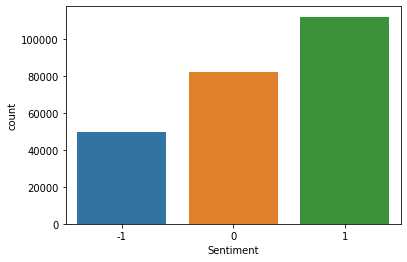

In [14]:
import seaborn as sns
ax=sns.countplot(data.Sentiment)

In [15]:
data.drop(["user_location", 
                                "user_description", "user_created", 
                                "user_followers", "user_friends", 
                                "user_favourites", "user_verified","date","hashtags", 
                                "source", "is_retweet" ,"Positive","Negative","Neutral","Compound"],axis=1,inplace=True)
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,user_name,text,Sentiment,cleaned
0,0,0,0,MyNewsNE,australia manufacture covid19 vaccine give cit...,1,australia manufactur covid vaccin give citizen...
1,1,1,7,AKisASocialisolationist wash yer damn hands,msnbc well let’s qualify would anyone party ge...,1,msnbc well let qualifi would anyon parti get v...
2,2,2,8,Dr. Joseph Santoro,countries without ability make vaccines locall...,-1,most countri without abil make vaccin local fo...
3,3,3,9,VUMC OAP,dna zooms charts 1st week hear vaccines episod...,0,dna zoom chart st week hear vaccin episod http...
4,4,4,11,Mohammadali Naseri,it’s covid19millionares covid19 corona covidva...,0,covid millionar covid corona covidvaccin


In [16]:
#Split data into training and testing sets 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data["text"], 
                                                    data["Sentiment"], test_size = 0.2, random_state = 42)

print("training set :",x_train.shape,y_train.shape)
print("testing set :",x_test.shape,y_test.shape)

training set : (195219,) (195219,)
testing set : (48805,) (48805,)


In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

print(x_train_counts.shape)
print(x_train_tfidf.shape)

(195219, 197244)
(195219, 197244)


In [18]:
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

print(x_test_counts.shape)
print(x_test_tfidf.shape)

(48805, 197244)
(48805, 197244)


In [19]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150)
model.fit(x_train_tfidf,y_train)

RandomForestClassifier(n_estimators=150)

In [20]:
predictions = model.predict(x_test_tfidf)
#Accuracy_score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)*100

83.18819793053991

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)*100

83.18819793053991

In [22]:
print("Classification Report : ")
print(classification_report(y_test,predictions))

Classification Report : 
              precision    recall  f1-score   support

          -1       0.86      0.60      0.71      9940
           0       0.77      0.93      0.84     16467
           1       0.88      0.87      0.87     22398

    accuracy                           0.83     48805
   macro avg       0.84      0.80      0.81     48805
weighted avg       0.84      0.83      0.83     48805



In [23]:
from sklearn.metrics import confusion_matrix,f1_score

from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test,predictions)

array([[ 5953,  2077,  1910],
       [  346, 15266,   855],
       [  614,  2403, 19381]])